# Part 1: Setup

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# create dataframes from the csv
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# turn values of dataframes into a tensor
train_tensor = torch.from_numpy(train.values).to(torch.float64)
test_tensor = torch.from_numpy(test.values).to(torch.float64)

# Construct the 4 tensors
trainX = train_tensor[:, :-1]
trainY = train_tensor[:, -1].unsqueeze(1)
testX = test_tensor[:, :-1]
testY = test_tensor[:, -1].unsqueeze(1)

In [3]:
#q1: about how many bytes does trainX consume?
num_bytes = trainX.nelement() * trainX.element_size()
num_bytes

83520

In [4]:
#q2: what is the biggest difference we would have any one cell if we used float16 instead of fQ2: what is the biggest difference we would have any one cell if we used float16 instead of f

# convert to float16 then back to float64
to_16 = trainX.to(torch.float16)
back_to_64 = trainX.to(torch.float64)
# Calculate the absolute difference between the original and adjusted
abs_diff = torch.abs(trainX - back_to_64)
# Find the biggest absolute difference
max_abs_diff = torch.max(abs_diff)
# Display the result as a Python float
float(max_abs_diff)

0.0

In [5]:
#q3: is a CUDA GPU available on your VM?
torch.cuda.is_available()

False

# Part 2: Prediction with Hardcoded Model

In [6]:
coef = torch.tensor([
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040], # POS_50_59_CP
        [0.0300], # POS_60_69_CP
        [0.0300],
        [0.0300],
        [0.0300]
], dtype=trainX.dtype)
coef

tensor([[0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0300],
        [0.0300],
        [0.0300],
        [0.0300]], dtype=torch.float64)

In [7]:
#q4: what is the predicted number of deaths for the first census tract?
(testX[0, :] @ coef).item()

9.844

In [8]:
#q5: what is the average number of predicted deaths, over the whole testX dataset?
torch.mean(testX @ coef).item()

12.073632183908048

# Part 3: Optimization

In [9]:
#q6: first, what is y when x is a tensor containing 0.0?
x = torch.tensor(0.0, requires_grad = True)
def f(x):
    return (x**2) - (8*x) + 19
float(f(x))

19.0

3.999999523162842

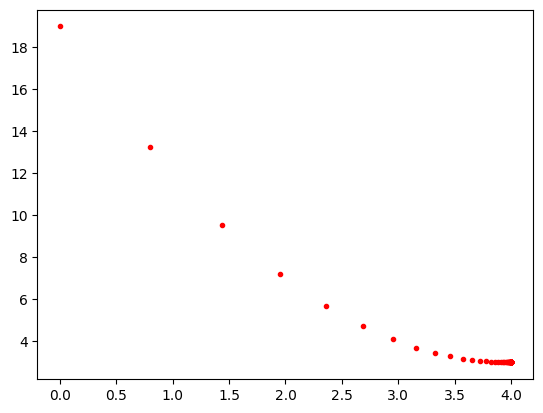

In [10]:
#q7: what x value minimizes y?

# Initialize x with an initial guess
x = torch.tensor(0.0, requires_grad=True)
# Create an optimizer
optimizer = torch.optim.SGD([x], lr=0.1)

for epoch in range(100):
    # Compute the function value
    y = f(x)
    plt.plot(x.detach(), y.detach(), "ro", markersize=3)   
    # Compute gradients and update x
    optimizer.zero_grad()
    y.backward()
    optimizer.step()

# The value of x that minimizes y
x_minimized = x.item()
x_minimized

# Part 4: Linear Regression

In [11]:
#q8: what is the MSE (mean-square error) when we make predictions using this vector of zero coefficients?
coef = torch.zeros((trainX.shape[1], 1),  dtype=torch.float64)
predict = trainX @ coef

# Calculate the Mean Squared Error (MSE)
mse = torch.mean((predict - trainY) ** 2)
float(mse)

197.8007662835249

In [12]:
torch.manual_seed(544)
ds = torch.utils.data.TensorDataset(trainX, trainY)
dl = torch.utils.data.DataLoader(ds, batch_size=50, shuffle=True)

# coefficients with zeros 
coef = torch.zeros((trainX.shape[1], 1), dtype=torch.float64, requires_grad=True)

# Define the loss function (MSE) and optimizer (SGD)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD([coef], lr=0.000002)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    for inputs, targets in dl:
        # Forward pass
        predictions = inputs @ coef
        loss = loss_function(predictions, targets.view(-1, 1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [13]:
#q9: what is the MSE over the training data, using the coefficients resulting from the above training?
predictions = trainX @ coef
mse_training = loss_function(predictions, trainY.view(-1, 1)).item()
mse_training

26.8113940147193

In [14]:
#q10: what is the MSE over the test data?
predictions = testX @ coef
mse_training = loss_function(predictions, testY.view(-1, 1)).item()
mse_training

29.05854692548551